# Конкурс OTP-банка 2011 года

Условие задачи: http://poligon.machinelearning.ru/Contests/Card.aspx?synonim=otp

In [1]:
%matplotlib inline

In [140]:
from __future__ import unicode_literals

import pandas as pd

pd.set_option('max_colwidth', 800)

from IPython.core import display as ICD

import catboost

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
!ls data/*.xls

data/answers.xls data/test.xls    data/train.xls


In [4]:
description = pd.read_excel("data/train.xls")

description

,ПОЛЕ,ОПИСАНИЕ
0,AGREEMENT_RK,уникальный идентификатор объекта в выборке
1,TARGET,"целевая переменная:отклик на маркетинговую кампанию (1 - отклик был зарегистрирован, 0 - отклика не было)"
2,AGE,возраст клиента
3,SOCSTATUS_WORK_FL,"социальный статус клиента относительно работы (1 - работает, 0 - не работает)"
4,SOCSTATUS_PENS_FL,"социальный статус клиента относительно пенсии (1 - пенсионер, 0 - не пенсионер)"
5,GENDER,пол клиента
6,CHILD_TOTAL,количество детей клиента
7,DEPENDANTS,количество иждивенцев клиента
8,EDUCATION,образование
9,MARITAL_STATUS,семейное положение


In [5]:
train_df = pd.read_excel("data/train.xls", sheetname="данные", index_col="AGREEMENT_RK")
test_df = pd.read_excel("data/test.xls", sheetname="данные", index_col="AGREEMENT_RK")

In [6]:
answers = pd.read_excel("data/answers.xls")

answers.index = test_df.index

In [7]:
train_df.head()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
AGREEMENT_RK,,,,,,,,,,,,,,,,,,,,,
59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,...,0,1,1,1,6,2,1,1580.000000,1580.0,NaN
59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,...,0,1,1,1,6,1,1,4020.000000,4020.0,NaN
59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,...,0,1,2,1,11,0,0,0.000000,0.0,NaN
59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,...,1,1,1,1,6,3,1,1589.923333,1590.0,NaN
59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,...,0,1,2,1,16,2,1,1152.150000,2230.0,NaN


In [56]:
train_df.describe()

,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,REG_FACT_FL,FACT_POST_FL,...,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,...,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,0.119030,40.406096,0.909610,0.134468,0.654536,1.099389,0.645208,13853.836323,0.838534,0.951192,...,0.054786,0.910136,1.387769,0.751889,7.875977,0.195362,0.130198,239.457144,243.021626,0.019050
std,0.323835,11.601068,0.286748,0.341165,0.475535,0.995411,0.812252,9015.467617,0.367973,0.215473,...,0.227569,0.285996,0.793566,0.988499,7.955747,0.685022,0.355702,827.700432,836.100116,0.137663
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8000.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,12000.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,17000.000000,1.000000,1.000000,...,0.000000,1.000000,2.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,1.000000,1.000000,...,1.000000,1.000000,11.000000,11.000000,114.000000,13.000000,8.000000,28012.200000,28012.200000,2.000000


In [8]:
assert len(set(train_df.index) & set(test_df.index)) == 0

In [9]:
for df in [train_df, test_df]:
    df.PREVIOUS_CARD_NUM_UTILIZED.fillna(0, inplace=True)

In [10]:
features = filter(lambda col: col != "TARGET", train_df.columns)

In [11]:
cat_features = filter(lambda feature: train_df[feature].dtype == 'O', features)

cat_features

[u'EDUCATION',
 u'MARITAL_STATUS',
 u'GEN_INDUSTRY',
 u'GEN_TITLE',
 u'ORG_TP_STATE',
 u'ORG_TP_FCAPITAL',
 u'JOB_DIR',
 u'FAMILY_INCOME',
 u'REG_ADDRESS_PROVINCE',
 u'FACT_ADDRESS_PROVINCE',
 u'POSTAL_ADDRESS_PROVINCE',
 u'TP_PROVINCE',
 u'REGION_NM']

In [12]:
for feature in cat_features:
    agg_df = train_df.groupby(feature).agg({'TARGET': ['mean', 'count']}).\
        sort_values(by=('TARGET', 'count'), ascending=False)
    ICD.display(agg_df)

TARGET      
                                    mean count
EDUCATION                                     
Среднее специальное             0.120589  6518
Среднее                         0.114768  4679
Высшее                          0.106926  3133
Неоконченное высшее             0.191729   532
Неполное среднее                0.141176   340
Два и более высших образования  0.200000    20
Ученая степень                  0.000000     1

TARGET      
                        mean count
MARITAL_STATUS                    
Состою в браке      0.112468  9416
Не состоял в браке  0.127554  3622
Разведен(а)         0.145382  1245
Вдовец/Вдова        0.088435   588
Гражданский брак    0.164773   352

TARGET      
                                               mean count
GEN_INDUSTRY                                             
Торговля                                   0.162264  2385
Другие сферы                               0.132241  1709
Металлургия/Промышленность/Машиностроение  0.109882  1356
Государственная служба                     0.113530  1286
Здравоохранение                            0.102804  1177
Образование                                0.111222   998
Транспорт                                  0.156290   787
Сельское хозяйство                         0.113960   702
Строительство                              0.101045   574
Коммунальное хоз-во/Дорожные службы        0.142589   533
Ресторанный бизнес/Общественное питание    0.186275   408
Наука                                      0.052109   403
Нефтегазовая промышленность                0.124444   225
Сборочные производства                     0.151163   172
Банк/Финансы                               0.130178   169
Энергетика                                 0.068966   145
Развлечения/Искусство                      0.148936   141
ЧОП/Детективная д-ть                       0.147059   136
Информационные услуги                      0.138889   108
Салоны красоты и здоровья                  0.090909    99
Информационные технологии                  0.129412    85
Химия/Парфюмерия/Фармацевтика              0.126984    63
СМИ/Реклама/PR-агенства                    0.081633    49
Юридические услуги/нотариальные услуги     0.042553    47
Страхование                                0.035714    28
Туризм                                     0.100000    20
Недвижимость                               0.375000    16
Управляющая компания                       0.166667    12
Логистика                                  0.090909    11
Подбор персонала                           0.000000     8
Маркетинг                                  0.000000     4

TARGET      
                                    mean count
GEN_TITLE                                     
Специалист                      0.115121  7010
Рабочий                         0.143740  3075
Служащий                        0.133850   904
Руководитель среднего звена     0.109039   697
Работник сферы услуг            0.136767   563
Высококвалифиц. специалист      0.131148   549
Руководитель высшего звена      0.168618   427
Индивидуальный предприниматель  0.170507   217
Другое                          0.096045   177
Руководитель низшего звена      0.161765   136
Военнослужащий по контракту     0.181818    88
Партнер                         0.230769    13

TARGET      
                                    mean count
ORG_TP_STATE                                  
Частная компания                0.139046  6523
Государственная комп./учреж.    0.107821  6112
Индивидуальный предприниматель  0.166144   957
Некоммерческая организация      0.135802   243
Частная ком. с инос. капиталом  0.190476    21

TARGET       
                     mean  count
ORG_TP_FCAPITAL                 
Без участия      0.127192  13688
С участием       0.123529    170

TARGET       
                                   mean  count
JOB_DIR                                       
Участие в основ. деятельности  0.126441  11452
Вспомогательный техперсонал    0.134634   1025
Бухгалтерия, финансы, планир.  0.099792    481
Адм-хоз. и трансп. службы      0.129032    279
Снабжение и сбыт               0.184332    217
Служба безопасности            0.121951    164
Кадровая служба и секретариат  0.118812    101
Пр-техн. обесп. и телеком.     0.106667     75
Юридическая служба             0.169811     53
Реклама и маркетинг            0.333333      9

TARGET      
                            mean count
FAMILY_INCOME                         
от 10000 до 20000 руб.  0.108662  7077
от 20000 до 50000 руб.  0.131042  6082
от 5000 до 10000 руб.   0.083333  1512
свыше 50000 руб.        0.231707   492
до 5000 руб.            0.100000    60

TARGET      
                                 mean count
REG_ADDRESS_PROVINCE                       
Краснодарский край           0.091988   674
Кемеровская область          0.102374   674
Алтайский край               0.159041   459
Читинская область            0.143192   426
Приморский край              0.117788   416
Ростовская область           0.108108   407
Свердловская область         0.140401   349
Волгоградская область        0.072508   331
Саратовская область          0.108761   331
Воронежская область          0.089701   301
Вологодская область          0.102740   292
Челябинская область          0.136986   292
Татарстан                    0.090592   287
Омская область               0.170732   287
Кировская область            0.075758   264
Архангельская область        0.085603   257
Оренбургская область         0.110672   253
Хабаровский край             0.115079   252
Тульская область             0.111111   252
Красноярский край            0.125523   239
Самарская область            0.140426   235
Башкирия                     0.121622   222
Курская область              0.096774   217
Белгородская область         0.102326   215
Новосибирская область        0.177570   214
Липецкая область             0.077670   206
Иркутская область            0.168317   202
Тюменская область            0.175879   199
Бурятия                      0.132653   196
Ярославская область          0.108247   194
...                               ...   ...
Калининградская область      0.137931   145
Орловская область            0.097222   144
Костромская область          0.090909   143
Псковская область            0.114286   140
Адыгея                       0.058394   137
Томская область              0.122137   131
Астраханская область         0.152672   131
Ленинградская область        0.215385   130
Кабардино-Балкария           0.196850   127
Калужская область            0.172131   122
Санкт-Петербург              0.128205   117
Нижегородская область        0.084112   107
Новгородская область         0.122449    98
Ханты-Мансийский АО          0.144330    97
Северная Осетия              0.234043    94
Карачаево-Черкесия           0.085106    94
Камчатская область           0.186813    91
Марийская республика         0.086420    81
Горный Алтай                 0.054054    74
Сахалинская область          0.238806    67
Еврейская АО                 0.089552    67
Москва                       0.379310    58
Хакасия                      0.092593    54
Калмыкия                     0.160000    25
Ямало-Ненецкий АО            0.250000    24
Магаданская область          0.227273    22
Дагестан                     0.000000     4
Усть-Ордынский Бурятский АО  0.500000     2
Агинский Бурятский АО        0.000000     2
Эвенкийский АО               0.000000     1

[81 rows x 2 columns]

TARGET      
                                 mean count
FACT_ADDRESS_PROVINCE                      
Кемеровская область          0.102374   674
Краснодарский край           0.090504   674
Алтайский край               0.160793   454
Читинская область            0.143192   426
Приморский край              0.115663   415
Ростовская область           0.106436   404
Свердловская область         0.140805   348
Волгоградская область        0.072289   332
Саратовская область          0.104938   324
Воронежская область          0.089701   301
Вологодская область          0.102740   292
Челябинская область          0.133562   292
Татарстан                    0.087413   286
Омская область               0.171329   286
Кировская область            0.078947   266
Архангельская область        0.086275   255
Хабаровский край             0.122047   254
Оренбургская область         0.108000   250
Тульская область             0.108434   249
Самарская область            0.138075   239
Красноярский край            0.126582   237
Башкирия                     0.117647   221
Новосибирская область        0.171296   216
Белгородская область         0.093458   214
Курская область              0.089202   213
Московская область           0.212560   207
Иркутская область            0.167488   203
Липецкая область             0.079208   202
Тюменская область            0.170854   199
Ярославская область          0.111111   198
...                               ...   ...
Пензенская область           0.062500   144
Орловская область            0.099291   141
Костромская область          0.092199   141
Адыгея                       0.064748   139
Санкт-Петербург              0.154412   136
Псковская область            0.111111   135
Томская область              0.119403   134
Астраханская область         0.147287   129
Кабардино-Балкария           0.196850   127
Ленинградская область        0.193277   119
Калужская область            0.168067   119
Нижегородская область        0.077670   103
Новгородская область         0.123711    97
Москва                       0.340206    97
Ханты-Мансийский АО          0.157895    95
Карачаево-Черкесия           0.086022    93
Северная Осетия              0.239130    92
Камчатская область           0.186813    91
Марийская республика         0.077922    77
Горный Алтай                 0.054795    73
Еврейская АО                 0.086957    69
Сахалинская область          0.238806    67
Хакасия                      0.090909    55
Ямало-Ненецкий АО            0.240000    25
Калмыкия                     0.125000    24
Магаданская область          0.227273    22
Агинский Бурятский АО        0.000000     2
Усть-Ордынский Бурятский АО  1.000000     1
Эвенкийский АО               0.000000     1
Дагестан                     1.000000     1

[81 rows x 2 columns]

TARGET      
                                 mean count
POSTAL_ADDRESS_PROVINCE                    
Кемеровская область          0.102374   674
Краснодарский край           0.091988   674
Алтайский край               0.160088   456
Читинская область            0.143192   426
Приморский край              0.115663   415
Ростовская область           0.106436   404
Свердловская область         0.140805   348
Волгоградская область        0.072508   331
Саратовская область          0.104294   326
Воронежская область          0.089404   302
Вологодская область          0.102389   293
Челябинская область          0.133562   292
Татарстан                    0.090592   287
Омская область               0.171329   286
Кировская область            0.078947   266
Архангельская область        0.086275   255
Хабаровский край             0.118110   254
Оренбургская область         0.111554   251
Тульская область             0.108434   249
Самарская область            0.138075   239
Красноярский край            0.125523   239
Башкирия                     0.117647   221
Новосибирская область        0.172093   215
Курская область              0.088785   214
Белгородская область         0.094340   212
Липецкая область             0.078431   204
Московская область           0.211823   203
Иркутская область            0.168317   202
Тюменская область            0.170854   199
Ярославская область          0.111675   197
...                               ...   ...
Калининградская область      0.137931   145
Пензенская область           0.062500   144
Орловская область            0.099291   141
Костромская область          0.092857   140
Адыгея                       0.057554   139
Псковская область            0.107914   139
Санкт-Петербург              0.150376   133
Томская область              0.120301   133
Астраханская область         0.146154   130
Кабардино-Балкария           0.198413   126
Калужская область            0.165289   121
Ленинградская область        0.201681   119
Нижегородская область        0.077670   103
Новгородская область         0.123711    97
Ханты-Мансийский АО          0.157895    95
Карачаево-Черкесия           0.085106    94
Северная Осетия              0.236559    93
Камчатская область           0.186813    91
Москва                       0.388235    85
Марийская республика         0.075949    79
Горный Алтай                 0.054795    73
Еврейская АО                 0.086957    69
Сахалинская область          0.238806    67
Хакасия                      0.092593    54
Калмыкия                     0.125000    24
Ямало-Ненецкий АО            0.250000    24
Магаданская область          0.227273    22
Усть-Ордынский Бурятский АО  0.500000     2
Агинский Бурятский АО        0.000000     2
Эвенкийский АО               0.000000     1

[80 rows x 2 columns]

TARGET      
                             mean count
TP_PROVINCE                            
Краснодарский край       0.086076   790
Кемеровская область      0.100299   668
Алтайский край           0.158257   436
Приморский край          0.116223   413
Читинская область        0.143204   412
Ставропольский край      0.138686   411
Ростовская область       0.108642   405
Челябинская область      0.138418   354
Свердловская область     0.144118   340
Волгоградская область    0.079646   339
Кировская область        0.072072   333
Саратовская область      0.107256   317
Воронежская область      0.092949   312
Красноярский край        0.118644   295
Вологодская область      0.099315   292
Омская область           0.171329   286
Татарстан                0.080882   272
Хабаровский край         0.116279   258
Санкт-Петербург          0.169291   254
Оренбургская область     0.111554   251
Тульская область         0.106122   245
Архангельская область    0.090535   243
Новосибирская область    0.172269   238
Самарская область        0.139831   236
Амурская область         0.129464   224
Курская область          0.084906   212
Бурятия                  0.132701   211
Белгородская область     0.094787   211
Ярославская область      0.110577   208
Иркутская область        0.171569   204
...                           ...   ...
Пермская область         0.111111   162
Чувашия                  0.075000   160
Смоленская область       0.100629   159
Мурманская область       0.168831   154
Пензенская область       0.064935   154
Башкирия                 0.090909   154
Рязанская область        0.098039   153
Ханты-Мансийский АО      0.184211   152
Ульяновская область      0.078947   152
Карелия                  0.133333   150
Тюменская область        0.161074   149
Калининградская область  0.137931   145
Орловская область        0.092857   140
Псковская область        0.109489   137
Костромская область      0.102941   136
Якутия                   0.171642   134
Томская область          0.115385   130
Астраханская область     0.147287   129
Калужская область        0.165289   121
Адыгея                   0.082474    97
Нижегородская область    0.063158    95
Новгородская область     0.126316    95
Камчатская область       0.186813    91
Марийская республика     0.076923    78
Горный Алтай             0.102564    78
Еврейская АО             0.088235    68
Сахалинская область      0.246154    65
Магаданская область      0.227273    22
Москва                   0.210526    19
Кабардино-Балкария       0.375000     8

[70 rows x 2 columns]

TARGET      
                        mean count
REGION_NM                         
ЮЖНЫЙ               0.103717  2179
ЦЕНТРАЛЬНЫЙ 2       0.104447  1934
ЗАПАДНО-СИБИРСКИЙ   0.135695  1835
ЦЕНТРАЛЬНЫЙ 1       0.102238  1653
ПОВОЛЖСКИЙ          0.099582  1436
ПРИВОЛЖСКИЙ         0.081890  1270
ВОСТОЧНО-СИБИРСКИЙ  0.143312  1256
УРАЛЬСКИЙ           0.143933  1195
ДАЛЬНЕВОСТОЧНЫЙ     0.132340  1141
СЕВЕРО-ЗАПАДНЫЙ     0.134241  1028
ЦЕНТРАЛЬНЫЙ ОФИС    0.264407   295

In [13]:
train_df.groupby('TP_PROVINCE').agg({'CREDIT': ['mean', 'count']}).\
    sort_values(by=('CREDIT', 'mean'), ascending=False)

CREDIT      
                                 mean count
TP_PROVINCE                                
Якутия                   26696.633209   134
Ханты-Мансийский АО      24869.796118   152
Камчатская область       23397.396703    91
Москва                   21700.890526    19
Хабаровский край         21439.993915   258
Сахалинская область      20439.815385    65
Мурманская область       19946.249351   154
Тюменская область        18823.655503   149
Приморский край          18603.353269   413
Санкт-Петербург          18439.032992   254
Амурская область         16788.504464   224
Магаданская область      16647.977273    22
Еврейская АО             16398.176471    68
Свердловская область     16279.744618   340
Читинская область        16248.991019   412
Пермская область         16062.033827   162
Адыгея                   15909.217113    97
Новосибирская область    15859.332059   238
Ставропольский край      15793.451752   411
Коми                     15527.237805   164
Краснодарский край       15071.059582   790
Кемеровская область      15070.019820   668
Калининградская область  15027.813379   145
Башкирия                 15025.317662   154
Томская область          14892.125000   130
Рязанская область        14815.232092   153
Бурятия                  14751.968246   211
Иркутская область        14663.309755   204
Калужская область        14560.299339   121
Красноярский край        14363.894237   295
...                               ...   ...
Татарстан                13512.771103   272
Новгородская область     13465.957895    95
Астраханская область     13456.743411   129
Самарская область        13443.862119   236
Нижегородская область    13426.431579    95
Курганская область       13368.117680   181
Саратовская область      13334.228044   317
Владимирская область     13049.795819   177
Кировская область        12990.672673   333
Волгоградская область    12955.452507   339
Кабардино-Балкария       12687.737500     8
Ульяновская область      12597.412829   152
Смоленская область       12540.627610   159
Алтайский край           12440.641835   436
Брянская область         12350.643575   179
Мордовская республика    12310.254329   164
Архангельская область    12217.219835   243
Тверская область         12185.666033   184
Воронежская область      12075.698910   312
Костромская область      11871.833015   136
Вологодская область      11787.564932   292
Чувашия                  11735.702500   160
Горный Алтай             11733.466667    78
Курская область          11512.477217   212
Ивановская область       11486.736301   173
Пензенская область       10950.532468   154
Удмуртия                 10893.785169   178
Псковская область        10643.863285   137
Орловская область        10641.963571   140
Марийская республика      8954.843590    78

[70 rows x 2 columns]

In [14]:
ICD.display(train_df.CREDIT.describe())

train_df.groupby('TP_PROVINCE').agg({'CREDIT': ['mean', 'count']}).\
    sort_values(by=('CREDIT', 'mean'), ascending=False)

count     15223.000000
mean      14667.959345
std       12147.873496
min        2000.000000
25%        6500.000000
50%       11550.000000
75%       19170.000000
max      119700.000000
Name: CREDIT, dtype: float64

CREDIT      
                                 mean count
TP_PROVINCE                                
Якутия                   26696.633209   134
Ханты-Мансийский АО      24869.796118   152
Камчатская область       23397.396703    91
Москва                   21700.890526    19
Хабаровский край         21439.993915   258
Сахалинская область      20439.815385    65
Мурманская область       19946.249351   154
Тюменская область        18823.655503   149
Приморский край          18603.353269   413
Санкт-Петербург          18439.032992   254
Амурская область         16788.504464   224
Магаданская область      16647.977273    22
Еврейская АО             16398.176471    68
Свердловская область     16279.744618   340
Читинская область        16248.991019   412
Пермская область         16062.033827   162
Адыгея                   15909.217113    97
Новосибирская область    15859.332059   238
Ставропольский край      15793.451752   411
Коми                     15527.237805   164
Краснодарский край       15071.059582   790
Кемеровская область      15070.019820   668
Калининградская область  15027.813379   145
Башкирия                 15025.317662   154
Томская область          14892.125000   130
Рязанская область        14815.232092   153
Бурятия                  14751.968246   211
Иркутская область        14663.309755   204
Калужская область        14560.299339   121
Красноярский край        14363.894237   295
...                               ...   ...
Татарстан                13512.771103   272
Новгородская область     13465.957895    95
Астраханская область     13456.743411   129
Самарская область        13443.862119   236
Нижегородская область    13426.431579    95
Курганская область       13368.117680   181
Саратовская область      13334.228044   317
Владимирская область     13049.795819   177
Кировская область        12990.672673   333
Волгоградская область    12955.452507   339
Кабардино-Балкария       12687.737500     8
Ульяновская область      12597.412829   152
Смоленская область       12540.627610   159
Алтайский край           12440.641835   436
Брянская область         12350.643575   179
Мордовская республика    12310.254329   164
Архангельская область    12217.219835   243
Тверская область         12185.666033   184
Воронежская область      12075.698910   312
Костромская область      11871.833015   136
Вологодская область      11787.564932   292
Чувашия                  11735.702500   160
Горный Алтай             11733.466667    78
Курская область          11512.477217   212
Ивановская область       11486.736301   173
Пензенская область       10950.532468   154
Удмуртия                 10893.785169   178
Псковская область        10643.863285   137
Орловская область        10641.963571   140
Марийская республика      8954.843590    78

[70 rows x 2 columns]

In [15]:
for feature in features:
    for df in [train_df, test_df]:
        if train_df[feature].dtype == 'O':
            df[feature].fillna('', inplace=True)
            df[feature] = df[feature].apply(lambda s: s.encode('utf-8'))
        else:
            df[feature].fillna(-1, inplace=True)

In [16]:
# def preprocess_region(s):
#     for region_type in ['область', 'край', 'АО', 'республика']:
#         if region_type in s:
#             return region_type
#     if not s:
#         return ''
#     return ''

# for feature in cat_features:
#     if 'PROVINCE' in feature:
#         for df in [train_df, test_df]:
#             df[feature + '_TYPE'] = df[feature].apply(preprocess_region)

In [17]:
# for feature in train_df.columns:
#     if feature.endswith('_TYPE'):
#         agg_df = train_df.groupby(feature).agg({target: ['mean', 'count']})
#         agg_df.sort_values(by=(target, 'count'), ascending=False, inplace=True)
#         ICD.display(agg_df)

In [18]:
cat_feature_indexes = [features.index(feature) for feature in cat_features]

train_pool = Pool(train_df[features], label=train_df.TARGET,
                  cat_features=cat_feature_indexes)
test_pool = Pool(test_df[features], label=answers,
                 cat_features=cat_feature_indexes)

In [138]:
est = CatBoostClassifier(
    custom_loss='AUC', eval_metric='AUC',
    # bagging_temperature=0.5, rsm=0.7,
    random_seed=42,
    # ctr_desciption=['MeanValue'],
    calc_feature_importance=True)

In [60]:
est = CatBoostClassifier(
    custom_loss='AUC', eval_metric='AUC',
    # bagging_temperature=0.5, rsm=0.7,
    random_seed=42,
    # ctr_desciption=['MeanValue'],
    calc_feature_importance=True)

est.fit(train_pool, eval_set=test_pool, plot=True)

In [59]:
prediction = est.predict_proba(test_pool)[:,1]

roc_auc_score(answers, prediction)

0.70491293964394264

In [21]:
sorted(zip(features, est.feature_importance), key=lambda item: item[1], reverse=True)

[(u'FST_PAYMENT', 9.519127656590982),
 (u'PERSONAL_INCOME', 9.013458341172468),
 (u'AGE', 6.595548803033744),
 (u'WORK_TIME', 5.557949431306838),
 (u'TERM', 5.12708972896081),
 (u'GEN_INDUSTRY', 4.982511846852999),
 (u'EDUCATION', 3.961234011609248),
 (u'FACT_LIVING_TERM', 3.690747264087877),
 (u'LOAN_NUM_PAYM', 3.5758126352804016),
 (u'REGION_NM', 3.0588481592966192),
 (u'LOAN_NUM_CLOSED', 2.8827385588306114),
 (u'PREVIOUS_CARD_NUM_UTILIZED', 2.742094564718953),
 (u'CHILD_TOTAL', 2.5418743131896413),
 (u'ORG_TP_FCAPITAL', 2.3714333513119805),
 (u'POSTAL_ADDRESS_PROVINCE', 2.2895531161506812),
 (u'GEN_TITLE', 2.237117676023358),
 (u'FACT_ADDRESS_PROVINCE', 2.215072606739657),
 (u'TP_PROVINCE', 2.1135297376471853),
 (u'ORG_TP_STATE', 2.1047412133267973),
 (u'REG_ADDRESS_PROVINCE', 2.004321639436128),
 (u'MARITAL_STATUS', 1.8592313467037935),
 (u'LOAN_MAX_DLQ_AMT', 1.8294407052251649),
 (u'FAMILY_INCOME', 1.772365297779211),
 (u'CREDIT', 1.7553437028417613),
 (u'LOAN_AVG_DLQ_AMT', 1.7304

In [22]:
for feature in features:
    for df in [train_df, test_df]:
        if train_df[feature].dtype == 'O':
            df[feature] = df[feature].apply(lambda s: s.decode('utf-8'))

In [23]:
train_X = pd.get_dummies(train_df, columns=cat_features)
test_X = pd.get_dummies(test_df, columns=cat_features)

new_features = list(set(train_X.columns) & set(test_X.columns))

for col in set(test_X.columns) - set(train_X.columns):
    print col

train_X = train_X[['TARGET'] + new_features]
test_X = test_X[new_features]

new_features = list(set(train_X.columns) & set(test_X.columns))

FACT_ADDRESS_PROVINCE_Коми-Пермяцкий АО
REG_ADDRESS_PROVINCE_Коми-Пермяцкий АО
POSTAL_ADDRESS_PROVINCE_Коми-Пермяцкий АО
POSTAL_ADDRESS_PROVINCE_Дагестан
FACT_ADDRESS_PROVINCE_Чечня


In [91]:
from lightgbm import LGBMClassifier
from transliterate import translit

lgbm_est = LGBMClassifier(
    learning_rate=0.005,
    num_leaves=15,
    n_estimators=1500,
    subsample=0.7,
    colsample_bytree=0.7,
    random_seed=42,
)

feature_names = map(lambda s: translit(s, language_code='ru', reversed=True), new_features)

lgbm_est.fit(train_X[new_features].values, train_df.TARGET, feature_name=feature_names)

lgbm_prediction = lgbm_est.predict_proba(test_X[new_features].values)

roc_auc_score(answers, lgbm_prediction[:,1])

0.70822314372557538

In [151]:
cross_val_score(lgbm_est, train_X[new_features].values, train_df.TARGET, scoring='roc_auc', cv=5)

array([ 0.66479076,  0.68429362,  0.7010096 ,  0.6918705 ,  0.70772203])

In [92]:
from eli5 import show_weights, explain_prediction

show_weights(lgbm_est, feature_names=feature_names)

Weight,Feature
0.0902,PERSONAL_INCOME
0.0880,FST_PAYMENT
0.0817,AGE
0.0653,WORK_TIME
0.0448,FACT_LIVING_TERM
0.0445,CREDIT
0.0394,TERM
0.0373,PREVIOUS_CARD_NUM_UTILIZED
0.0357,LOAN_NUM_PAYM
0.0333,LOAN_AVG_DLQ_AMT


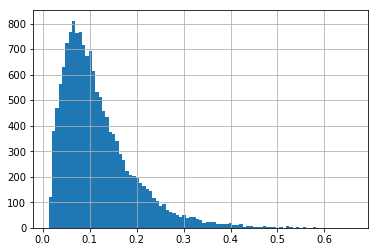

In [94]:
prediction = pd.Series(lgbm_prediction[:,1])

prediction.hist(bins='auto')

In [52]:
prediction.describe()

count    14910.000000
mean         0.117202
std          0.077197
min          0.012225
25%          0.062862
50%          0.098445
75%          0.151092
max          0.660846
dtype: float64

In [152]:
prediction.quantile(0.8)

0.16753382259402438

In [54]:
explain_prediction(lgbm_est, test_X.iloc[prediction.argmax()].values, feature_names=feature_names)

Explanation(estimator="LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.7,\n        learning_rate=0.005, max_bin=255, max_depth=-1,\n        min_child_samples=10, min_child_weight=5, min_split_gain=0,\n        n_estimators=1500, nthread=-1, num_leaves=15, objective='binary',\n        random_seed=42, reg_alpha=0, reg_lambda=0, seed=0, silent=True,\n        subsample=0.7, subsample_for_bin=50000, subsample_freq=1)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature=u'PERSONAL_INCOME', weight=0.56220172180931738, std=None, value=70000.0), FeatureWeight(feature=u'FST_PAYMENT', weight=0.33490698154209775, std=None, value=0.0), FeatureWeight(feature=u'FACT_ADDRESS_PROVINCE_Severnaja Osetija', weight=0.23203091314250893, std=None, value=1.0), FeatureWeight(feature=u'LOAN_AVG_DLQ_AMT', weight=0.16036980483455701, std=None, value=1670.0), FeatureWeight(feature=u'AGE', weight=0.1097546129633869, std=None, value=33.0), FeatureWeight(feature=u'LOAN_NUM_CLOSED', weight=0.089527967025456096, std=None, value=0.0), FeatureWeight(feature=u'JOB_DIR_Snabzhenie i sbyt', weight=0.087984371229254218, std=None, value=1.0), FeatureWeight(feature=u"GEN_TITLE_Rukovoditel' vysshego zvena", weight=0.083369190241748534, std=None, value=1.0), FeatureWeight(feature=u'FACT_ADDRESS_PROVINCE_Altajskij kraj', weight=0.068164615921749314, std=None, value=1.0), FeatureWeight(feature=u'LOAN_NUM_PAYM', weight=0.065483538236697766, std=None, value=4.0), FeatureWeight(feature=u'REG_FACT_POST_TP_FL', weight=0.060293299191028028, std=None, value=0.0), FeatureWeight(feature=u'TP_PROVINCE_', weight=0.05997205895409341, std=None, value=1.0), FeatureWeight(feature=u'EDUCATION_Vysshee', weight=0.039963098382831262, std=None, value=0.0), FeatureWeight(feature=u"TP_PROVINCE_Cheljabinskaja oblast'", weight=0.039439409773719861, std=None, value=3.0), FeatureWeight(feature=u'REG_ADDRESS_PROVINCE_Kabardino-Balkarija', weight=0.036897283682149208, std=None, value=1.0), FeatureWeight(feature=u'FACT_PHONE_FL', weight=0.027399140838913035, std=None, value=0.0), FeatureWeight(feature=u'REG_POST_FL', weight=0.022999679054282331, std=None, value=0.0), FeatureWeight(feature=u'WORK_TIME', weight=0.022397782354135757, std=None, value=0.0), FeatureWeight(feature=u'ORG_TP_STATE_Nekommercheskaja organizatsija', weight=0.017277981864221914, std=None, value=1.0), FeatureWeight(feature=u'DEPENDANTS', weight=0.017276512266463467, std=None, value=0.0), FeatureWeight(feature=u'SOCSTATUS_PENS_FL', weight=0.012400224188909053, std=None, value=0.0), FeatureWeight(feature=u'LOAN_NUM_TOTAL', weight=0.011794109303208216, std=None, value=0.0), FeatureWeight(feature=u'LOAN_MAX_DLQ', weight=0.011593335451227576, std=None, value=1.0), FeatureWeight(feature=u'REGION_NM_PRIVOLZhSKIJ', weight=0.010843047769376359, 

In [39]:
answers.iloc[prediction.argmax()]

TARGET    1
Name: 62590808, dtype: int64

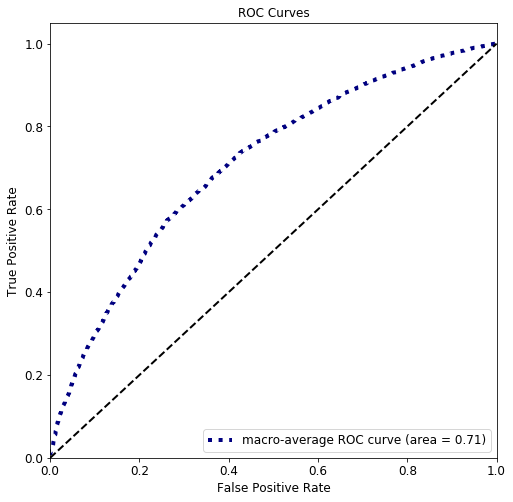

In [105]:
import scikitplot.plotters as skplt

skplt.plot_roc_curve(y_true=answers, y_probas=lgbm_prediction,
                     curves='macro', figsize=(8,8), text_fontsize='large')

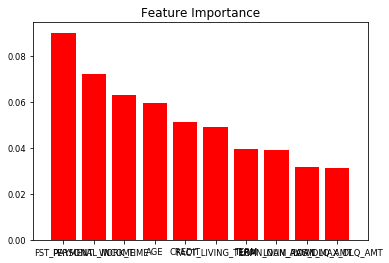

In [111]:
skplt.plot_feature_importances(lgbm_est, feature_names=feature_names, max_num_features=10, )

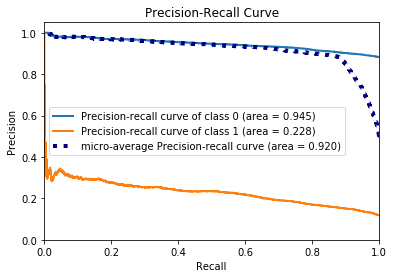

In [112]:
skplt.plot_precision_recall_curve(answers, lgbm_prediction)

In [134]:
top_rate = 0.2

top = answers[(prediction > prediction.quantile(1. - top_rate)).values]

print "True rate: {}".format(top.mean())
print "True rate: {}".format(top.mean() / answers.mean())
print "True rate: {}".format(top.sum() / answers.sum())

True rate: TARGET    0.238431
dtype: float64
True rate: TARGET    2.031429
dtype: float64
True rate: TARGET    0.406286
dtype: float64


In [ ]:
skplt.pl